In [20]:
# Import libraries
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install ultralytics kagglehub --quiet
import os
import random
import glob
import cv2
import time
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import kagglehub
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

In [2]:
# Download dataset
data_dir = kagglehub.dataset_download("pkdarabi/cardetection")

100%|██████████| 99.8M/99.8M [00:00<00:00, 155MB/s]

Extracting files...


In [3]:
# YOLOv8 모델 초기화
print("⏳Loading YOLOv8 model...")
model = YOLO("yolov8n.pt")

⏳Loading YOLOv8 model...


100%|██████████| 6.25M/6.25M [00:00<00:00, 76.1MB/s]


Displaying sample images from the dataset...


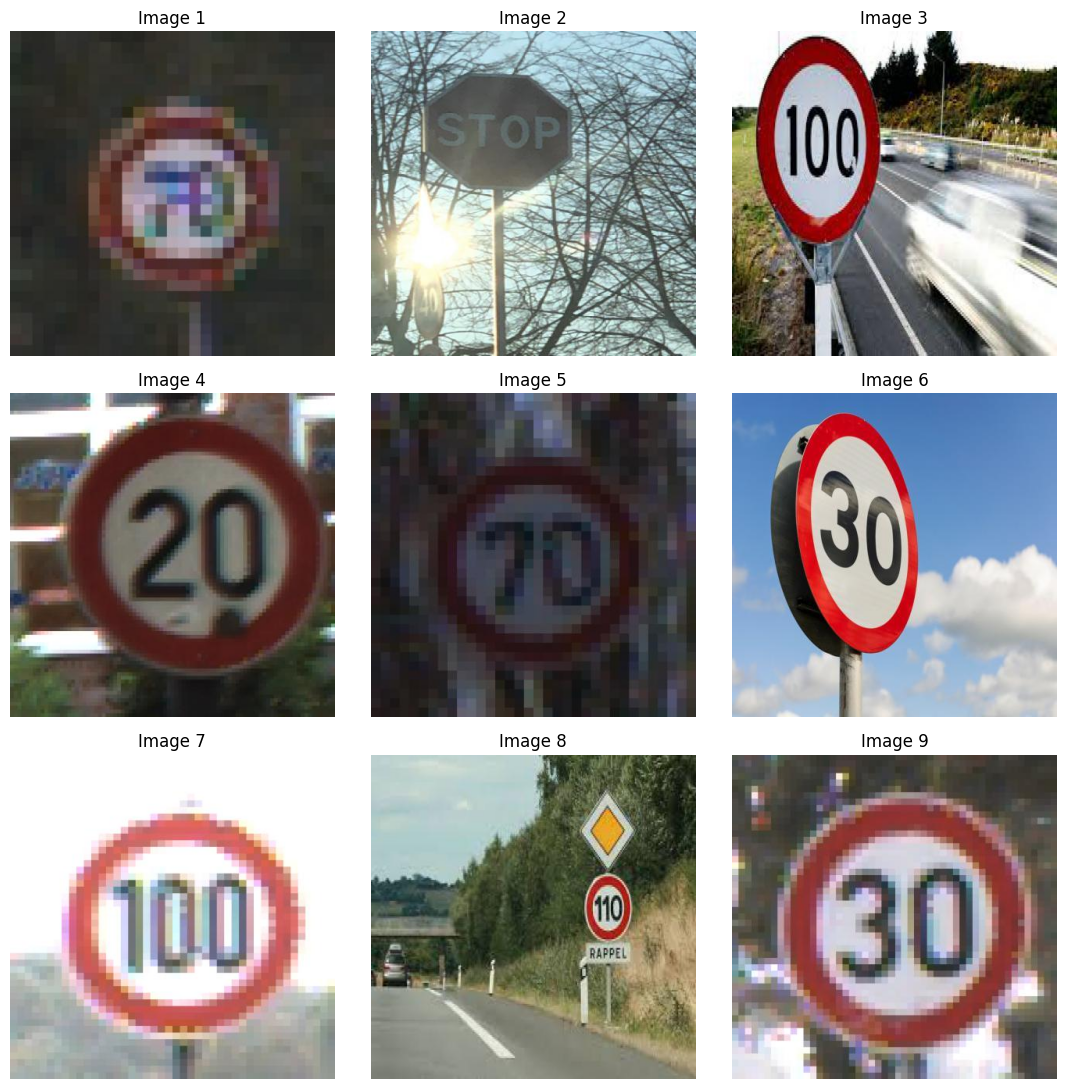

In [4]:
image_dir = os.path.join(data_dir, 'car/train/images')
image_files = os.listdir(image_dir)

num_samples = 9
rand_images = random.sample(image_files, num_samples)

print("Displaying sample images from the dataset...")
fig, axes = plt.subplots(3, 3, figsize=(11, 11))
for i, ax in enumerate(axes.flatten()):
    image = rand_images[i]
    ax.imshow(cv2.cvtColor(cv2.imread(os.path.join(image_dir, image)), cv2.COLOR_BGR2RGB))
    ax.set_title(f"Image {i+1}")
    ax.axis("off")
plt.tight_layout()
plt.show()

⏳Applying data augmentation to sample images...


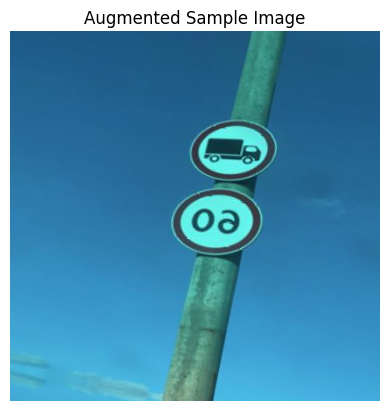

In [5]:
def normalize_image(image):
    return image / 255.0

# Data augmentation
print("⏳Applying data augmentation to sample images...")
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),  # 좌우 뒤집기
    A.Rotate(limit=15, p=0.5),  # 랜덤 회전
    A.RandomScale(scale_limit=0.2, p=0.5),  # 랜덤 크기 조정
    ToTensorV2()  # 텐서 변환
])

aug_image_path = os.path.join(image_dir, random.choice(image_files))
aug_image = cv2.imread(aug_image_path)
aug_image = cv2.cvtColor(aug_image, cv2.COLOR_BGR2RGB)
aug_image = normalize_image(aug_image)
aug_result = augmentation_pipeline(image=aug_image)
aug_image_augmented = aug_result['image']

plt.imshow(aug_image_augmented.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
plt.title("Augmented Sample Image")
plt.axis("off")
plt.show()

In [6]:
# Train the model with transfer learning
train_data = os.path.join(data_dir, "car/data.yaml")

print("Starting YOLOv8 training with transfer learning...🏃")
model.train(
    data=train_data,  # 데이터셋 설정 파일
    epochs=30,  # 학습 반복 수
    imgsz=640,  # 이미지 크기
    batch=16,  # 배치 크기
    optimizer="Adam",  # 옵티마이저
    augment=True  # 데이터 증강 활성화
)

Starting YOLOv8 training with transfer learning...🏃
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/car/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

100%|██████████| 755k/755k [00:00<00:00, 15.0MB/s]


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 61.8MB/s]


AMP: checks passed ✅


train: Scanning /root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/car/train/labels... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530/3530 [00:03<00:00, 1093.99it/s]


train: New cache created: /root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/car/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/car/valid/labels... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<00:00, 1034.44it/s]

val: New cache created: /root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/car/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.25G       1.12       2.71      1.349         16        640: 100%|██████████| 221/221 [00:35<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.51it/s]


                   all        801        944      0.195     0.0858      0.031     0.0153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.22G       1.08      2.247      1.317         28        640: 100%|██████████| 221/221 [00:32<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.33it/s]


                   all        801        944     0.0983      0.148     0.0725      0.038

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.22G       1.01      2.073      1.265         29        640: 100%|██████████| 221/221 [00:32<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.88it/s]

                   all        801        944     0.0872      0.411       0.15     0.0831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.22G      0.941      1.949      1.215         20        640: 100%|██████████| 221/221 [00:32<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.05it/s]


                   all        801        944      0.141      0.456      0.199      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.21G     0.8837      1.872       1.17         28        640: 100%|██████████| 221/221 [00:32<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.92it/s]


                   all        801        944      0.163      0.564      0.248      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.21G     0.8485      1.797      1.146         31        640: 100%|██████████| 221/221 [00:32<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.02it/s]

                   all        801        944      0.231      0.532      0.262      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.21G      0.853      1.778      1.144         24        640: 100%|██████████| 221/221 [00:32<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.97it/s]

                   all        801        944      0.225      0.571      0.258      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.21G     0.7999      1.712      1.125         21        640: 100%|██████████| 221/221 [00:32<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.92it/s]


                   all        801        944      0.248      0.502      0.297      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.21G     0.7936      1.693      1.114         29        640: 100%|██████████| 221/221 [00:32<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.00it/s]


                   all        801        944      0.184      0.524      0.304      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30       2.2G     0.7678      1.658      1.099         24        640: 100%|██████████| 221/221 [00:32<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.01it/s]


                   all        801        944      0.307        0.5       0.34      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.21G     0.7521      1.602      1.084         18        640: 100%|██████████| 221/221 [00:32<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.06it/s]


                   all        801        944      0.342       0.46      0.343      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.22G     0.7593      1.585      1.092         15        640: 100%|██████████| 221/221 [00:32<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.11it/s]

                   all        801        944       0.47      0.514      0.382      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.21G     0.7439      1.568      1.087         23        640: 100%|██████████| 221/221 [00:32<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.01it/s]

                   all        801        944      0.385      0.543      0.381      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.21G     0.7311      1.553      1.076         16        640: 100%|██████████| 221/221 [00:32<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.05it/s]

                   all        801        944      0.386      0.499      0.397      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.22G     0.7181      1.513      1.066         20        640: 100%|██████████| 221/221 [00:32<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.86it/s]

                   all        801        944      0.468      0.551      0.451      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.21G     0.7198      1.494      1.069         23        640: 100%|██████████| 221/221 [00:32<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.99it/s]

                   all        801        944       0.34      0.603      0.487       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.21G      0.704      1.445      1.063         14        640: 100%|██████████| 221/221 [00:32<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.01it/s]

                   all        801        944       0.39      0.578      0.481      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30       2.2G      0.695      1.374      1.058         26        640: 100%|██████████| 221/221 [00:32<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.03it/s]

                   all        801        944      0.515      0.605      0.559       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.21G     0.6958      1.349      1.046         20        640: 100%|██████████| 221/221 [00:32<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.00it/s]

                   all        801        944      0.478      0.636      0.597      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.21G     0.6873      1.298      1.045         25        640: 100%|██████████| 221/221 [00:32<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.97it/s]

                   all        801        944      0.483      0.562      0.562      0.462


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30       2.2G      0.672      1.134      1.036         11        640: 100%|██████████| 221/221 [00:33<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.98it/s]

                   all        801        944       0.57      0.665      0.664      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.18G     0.6605      1.062       1.03         19        640: 100%|██████████| 221/221 [00:32<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.97it/s]


                   all        801        944      0.659      0.674      0.699      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.22G     0.6508     0.9759      1.024         11        640: 100%|██████████| 221/221 [00:32<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.08it/s]


                   all        801        944      0.733      0.706       0.77      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.19G     0.6332     0.9056      1.008         10        640: 100%|██████████| 221/221 [00:32<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.98it/s]


                   all        801        944      0.814      0.701      0.794      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.19G     0.6276     0.8423      1.005         12        640: 100%|██████████| 221/221 [00:32<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.04it/s]


                   all        801        944      0.856      0.712       0.82      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       2.2G     0.6075     0.7772     0.9991         10        640: 100%|██████████| 221/221 [00:32<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.95it/s]

                   all        801        944      0.853      0.722      0.826      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30       2.2G     0.5986     0.7316     0.9908         13        640: 100%|██████████| 221/221 [00:32<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.11it/s]


                   all        801        944       0.87      0.754       0.86       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.19G     0.5787     0.6853     0.9818         10        640: 100%|██████████| 221/221 [00:32<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.00it/s]


                   all        801        944      0.869      0.766      0.866      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.19G      0.578     0.6337     0.9735         12        640: 100%|██████████| 221/221 [00:32<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.03it/s]

                   all        801        944      0.868      0.789      0.885       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.19G     0.5604      0.597     0.9661         13        640: 100%|██████████| 221/221 [00:32<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.06it/s]


                   all        801        944      0.909      0.789       0.89      0.765

30 epochs completed in 0.317 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:08<00:00,  3.07it/s]


                   all        801        944      0.877      0.783      0.881      0.758
           Green Light         87        122      0.804      0.648      0.732      0.415
             Red Light         74        108      0.823      0.646      0.758      0.456
       Speed Limit 100         52         52      0.837      0.923      0.931      0.859
       Speed Limit 110         17         17      0.922      0.697      0.905       0.82
       Speed Limit 120         60         60      0.911      0.858      0.936      0.861
        Speed Limit 20         56         56      0.982      0.893      0.977      0.848
        Speed Limit 30         71         74      0.789      0.865      0.921      0.851
        Speed Limit 40         53         55      0.925      0.873      0.953      0.837
        Speed Limit 50         68         71      0.868      0.704      0.863      0.778
        Speed Limit 60         76         76      0.879      0.789      0.886      0.796
        Speed Limit 7

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b834c0ede40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [7]:
# Evaluate the model
print("Evaluating the trained model...🖋️")
metrics = model.val()

# IoU 출력
iou_thresholds = metrics.results_dict.get("metrics/iou_thres", [])
mean_iou = np.mean(iou_thresholds) if iou_thresholds else 0
print(f"Mean IoU: {mean_iou:.4f}")

# 기존 지표 출력
print("Model Evaluation Metrics:")
print(f"Precision: {metrics.results_dict['metrics/precision(B)']}")
print(f"Recall: {metrics.results_dict['metrics/recall(B)']}")
print(f"mAP@50: {metrics.results_dict['metrics/mAP50(B)']}")
print(f"mAP@50-95: {metrics.results_dict['metrics/mAP50-95(B)']}")

Evaluating the trained model...🖋️
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/car/valid/labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:11<00:00,  4.28it/s]


                   all        801        944      0.878      0.783      0.881      0.758
           Green Light         87        122      0.813      0.648      0.735       0.42
             Red Light         74        108      0.823      0.647      0.756      0.456
       Speed Limit 100         52         52       0.84      0.923      0.931      0.856
       Speed Limit 110         17         17      0.922      0.697      0.905      0.823
       Speed Limit 120         60         60      0.911      0.858      0.936      0.861
        Speed Limit 20         56         56      0.982      0.893      0.977      0.847
        Speed Limit 30         71         74      0.788      0.865      0.921      0.851
        Speed Limit 40         53         55      0.925      0.873      0.953      0.839
        Speed Limit 50         68         71      0.868      0.704      0.863      0.779
        Speed Limit 60         76         76      0.879      0.789      0.886      0.796
        Speed Limit 7

Visualizing predictions on the validation set...

0: 640x640 1 Speed Limit 80, 78.2ms
Speed: 2.5ms preprocess, 78.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 30, 28.5ms
Speed: 3.0ms preprocess, 28.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 25.8ms
Speed: 2.7ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 70, 25.5ms
Speed: 2.7ms preprocess, 25.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 30, 1 Speed Limit 50, 31.1ms
Speed: 2.4ms preprocess, 31.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 40, 26.6ms
Speed: 2.6ms preprocess, 26.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 40, 26.7ms
Speed: 2.9ms preprocess, 26.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 6

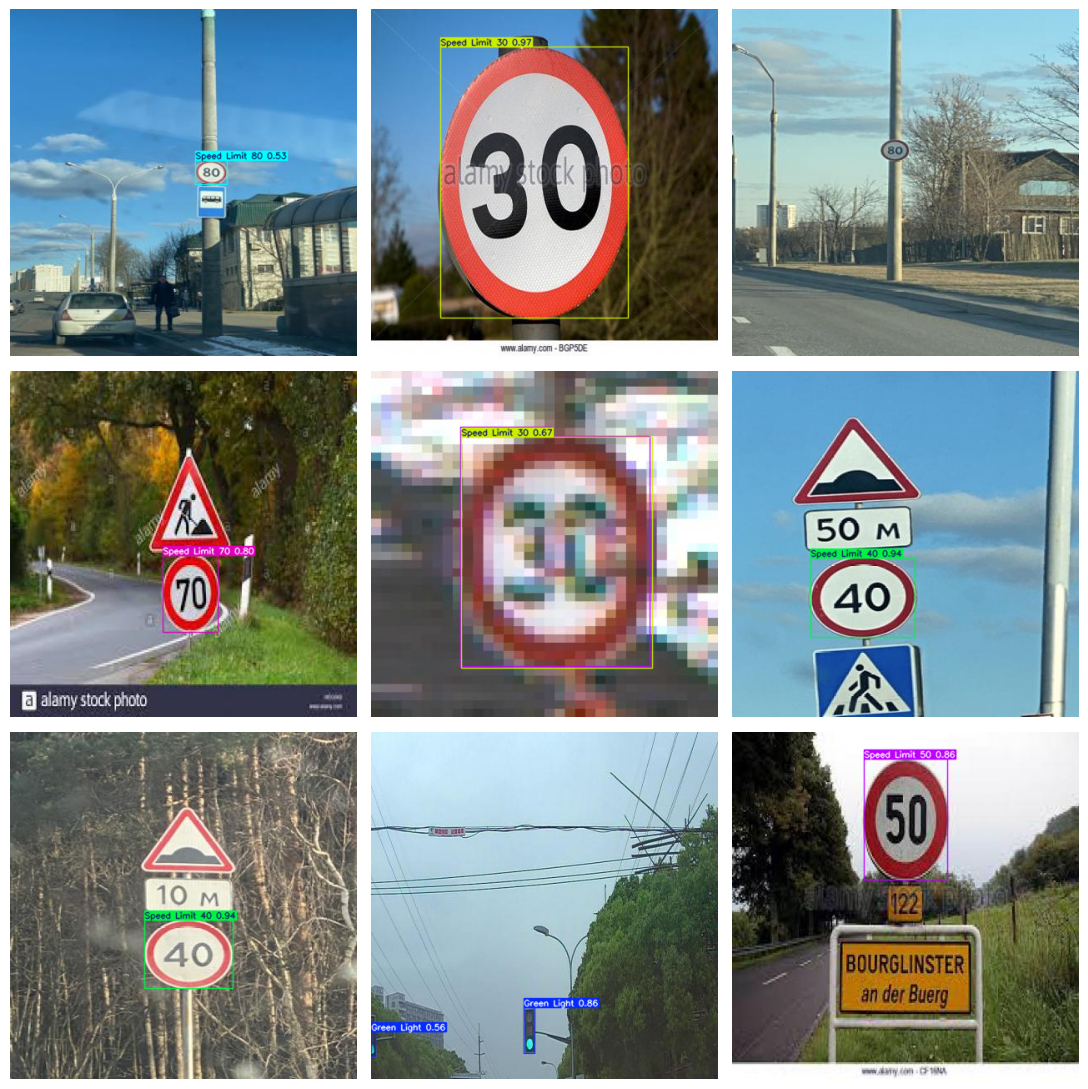

In [8]:
# Process a sample validation set for predictions
valid_images_path = os.path.join(data_dir, "car/test/images")
valid_image_files = [f for f in os.listdir(valid_images_path) if f.endswith(".jpg")]

if len(valid_image_files) > 0:
    print("Visualizing predictions on the validation set...")
    fig, axes = plt.subplots(3, 3, figsize=(11, 11))
    step_size = max(1, len(valid_image_files) // 9)
    selected_images = [valid_image_files[i] for i in range(0, len(valid_image_files), step_size)]

    for i, ax in enumerate(axes.flatten()):
        if i < len(selected_images):
            image_path = os.path.join(valid_images_path, selected_images[i])
            image = cv2.imread(image_path)
            if image is not None:
                results = model.predict(source=image, imgsz=640, conf=0.5)
                annotated_image = results[0].plot(line_width=1)
                ax.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            else:
                print(f"Failed to load image: {image_path}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Running object detection on video...


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/508) /root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/video.mp4: 640x640 1 Stop, 31.4ms
video 1/1 (frame 2/508) /root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/video.mp4: 640x640 1 Stop, 26.4ms
video 1/1 (frame 3/508) /root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/video.mp4: 640x640 1 Stop, 29.3ms
video 1/1 (frame 4/508) /root/.cache/kagglehub/dat

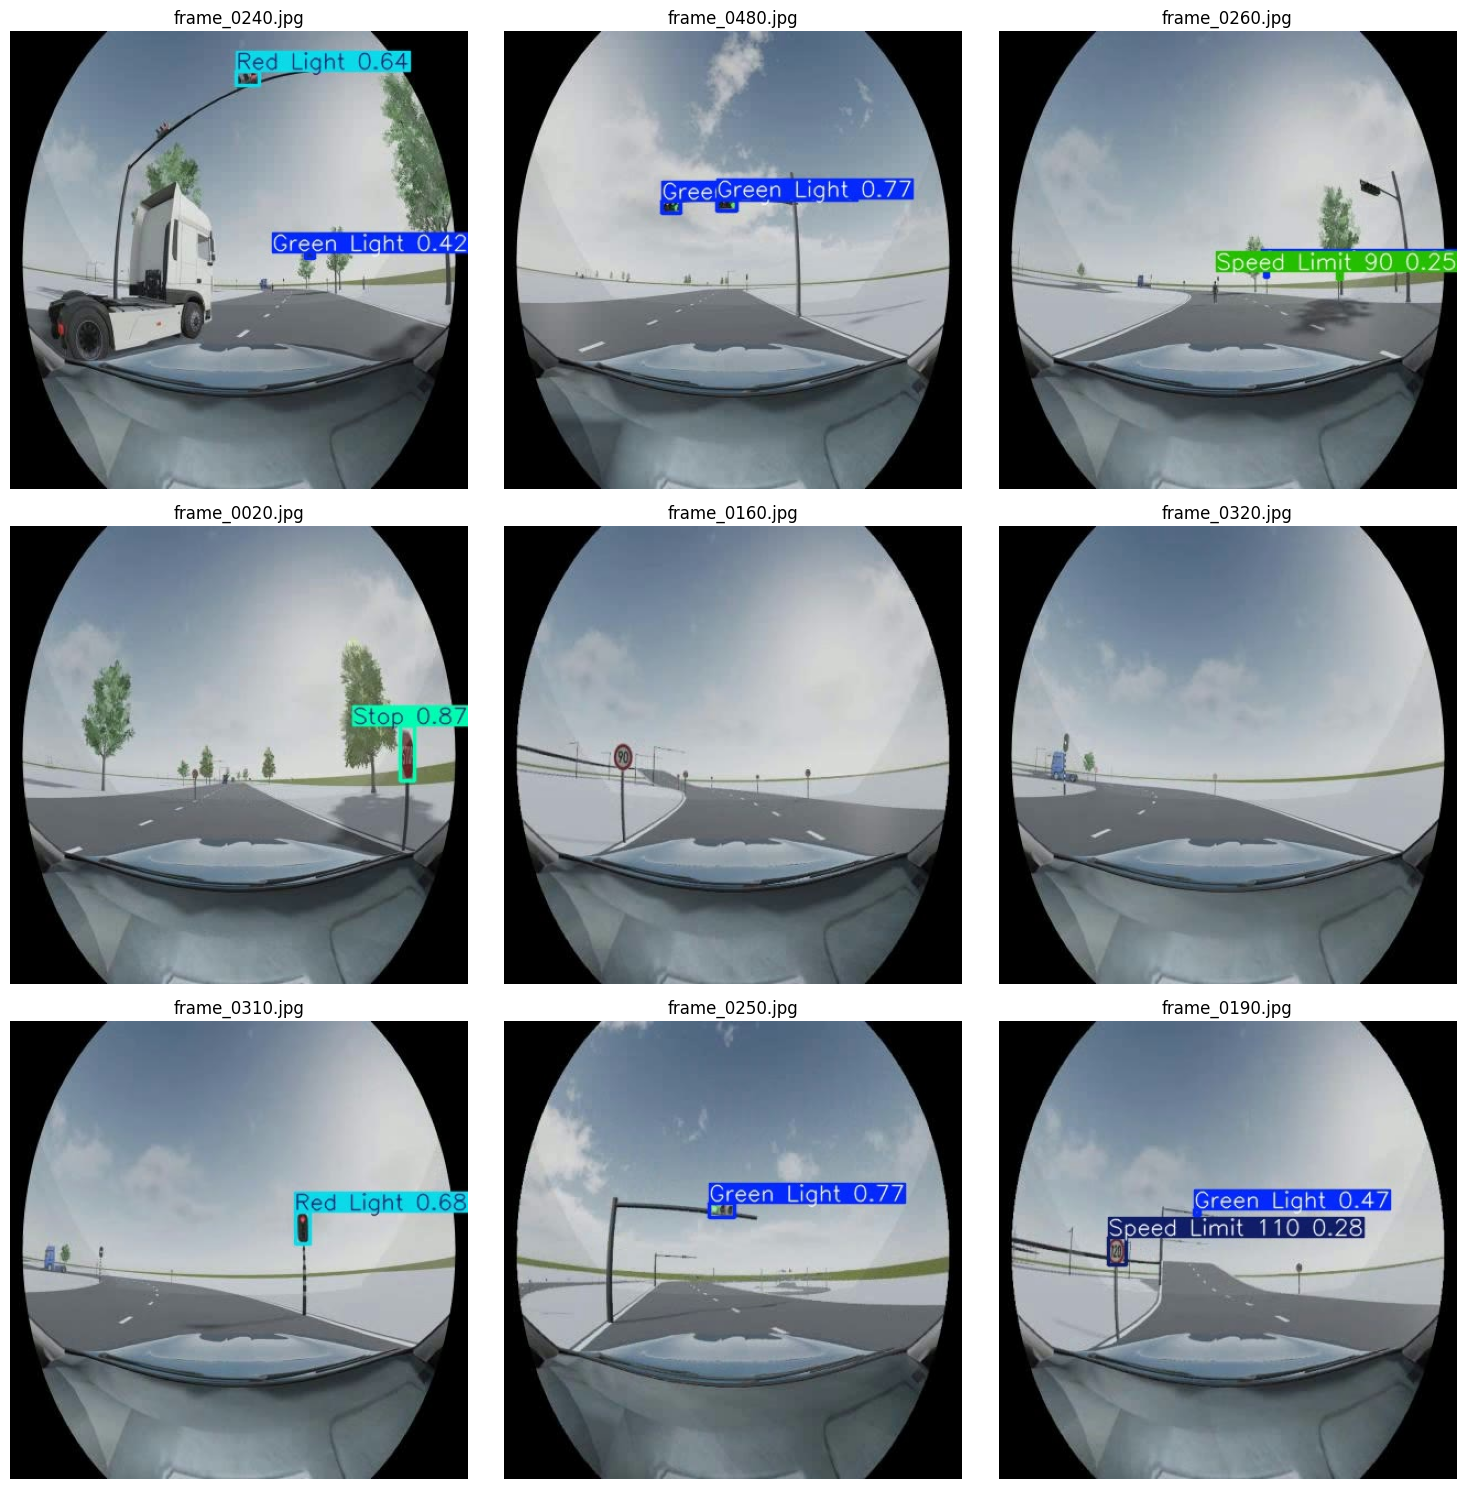

In [22]:
# Input 및 Output 설정
input_video_path = f"{data_dir}/video.mp4"  # 입력 비디오 경로
output_video_path = "result_out.mp4"  # 변환된 비디오 경로

print("Running object detection on video...")
results = model.predict(source=input_video_path, save=True, save_txt=True, save_conf=True)

# 저장된 결과 디렉토리 추출
if results and hasattr(results[0], 'save_dir'):
    result_dir = results[0].save_dir
    print(f"Results saved to: {result_dir}")
else:
    raise AttributeError("Could not retrieve save directory from results.")

# AVI 파일 경로
avi_path = os.path.join(result_dir, "video.avi")

if os.path.exists(avi_path):
    print(f"AVI file found at: {avi_path}")

    # AVI -> MP4 변환
    !ffmpeg -y -loglevel panic -i {avi_path} {output_video_path}
    print(f"MP4 file saved at: {output_video_path}")

    # 탐지된 이미지 저장 경로 설정
    detect_image_dir = os.path.join(result_dir, "frames")
    os.makedirs(detect_image_dir, exist_ok=True)

    print("Extracting frames from AVI file...")
    cap = cv2.VideoCapture(avi_path)
    frame_count = 0
    save_interval = 10  # 10 프레임마다 이미지 저장

    # AVI 파일에서 프레임 저장
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % save_interval == 0:  # 간격에 따라 저장
            frame_path = os.path.join(detect_image_dir, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_path, frame)
        frame_count += 1
    cap.release()
    print(f"Frames extracted and saved to: {detect_image_dir}")

    # 저장된 이미지 중 랜덤하게 9개 선택
    image_files = sorted(glob.glob(os.path.join(detect_image_dir, '*.jpg')))
    if image_files:
        random_images = random.sample(image_files, min(9, len(image_files)))
        print("Displaying 9 random detection images...")
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        axes = axes.flatten()
        for img_path, ax in zip(random_images, axes):
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(os.path.basename(img_path))
        plt.tight_layout()
        plt.show()
    else:
        print("No detection images found to display.")

else:
    raise FileNotFoundError(f"AVI file not found at: {avi_path}")

In [23]:
# Export the trained model
print("Exporting the model in ONNX format...")
model.export(format="onnx")

Exporting the model in ONNX format...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.30GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 19, 8400) (6.0 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.44...
ONNX: export success ✅ 1.6s, saved as 'runs/detect/train/weights/best.onnx' (11.7 MB)

Export complete (1.8s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.onnx imgsz=640 data=/root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/car/data.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best.onnx'